In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
    }
plt.rcParams.update(tex_fonts)

In [86]:
# read in data
df_PM10 = pd.read_csv('../air_weather_data/PM10_all_stations_cleaned.csv')
df_PM10['date'] = pd.to_datetime(df_PM10['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_PM10 = df_PM10.set_index('date') # date column as index

df_weather = pd.read_csv('../air_weather_data/metdata.csv')
df_weather['date'] = pd.to_datetime(df_weather['date'], format = '%Y-%m-%d %H:%M') # change time column to pandas datetime
df_weather = df_weather.set_index('date') # date column as index

In [87]:
# drop negative and zero values and interpolate (in order to log transform)
df_PM10[df_PM10 <= 0] = np.NaN
df_PM10.interpolate(inplace=True)

In [88]:
# create lagged values
for i in df_PM10.columns:
    df_PM10[str(i) + ', lag1'] = df_PM10[i].shift(1)

# additional lags for the target station
lags = 2
j = 2
for i in range(lags-1):
    df_PM10['PM$_{10}$, Stockholm Torkel Knutssonsgatan' + ', lag' + \
        str(j)] = df_PM10['PM$_{10}$, Stockholm Torkel Knutssonsgatan'].shift(j)
    j += 1

# drop NaN values
df_PM10.dropna(inplace=True)

In [89]:
# split into train an test sets
df_PM10_train = df_PM10['2016-01-01 00:00':'2019-01-01 00:00']
df_PM10_test = df_PM10['2020-09-01':]

df_weather_train = df_weather['2016-01-01 00:00':'2019-01-01 00:00']
df_weather_test = df_weather['2020-09-01':]

In [90]:
# log transform data
df_PM10_train = np.log(df_PM10_train)

In [91]:
# if only some stations are to be included
            # include all lagged values at Torkel Knutssonsgatan
stations = [i for i in df_PM10_train.columns if 'Torkel' in i and 'lag' in i] + \
           [
            'PM$_{10}$, Stockholm Hornsgatan 108 , lag1',
            'PM$_{10}$, Stockholm Sveavägen 59 , lag1',
            'PM$_{10}$, Stockholm E4/E20 Lilla Essingen, lag1',
            'PM$_{10}$, Norr Malma, lag1',
            'PM$_{10}$, Sollentuna Ekmans Väg 11, lag1',
           ]

In [92]:
# create y and X matrix
y_train = df_PM10_train['PM$_{10}$, Stockholm Torkel Knutssonsgatan']
X_train = df_PM10_train[[i for i in df_PM10_train.columns if 'lag' in i]]
# possibility to exclude some stations
X_train = X_train[stations]
X_train.insert(0, 'intercept', 1) # insert a 1

In [93]:
n1, n2 = 6,8
w = [0,1,2,3,4,5]

# if temporal signals are to be included
X_train = X_train.merge(df_weather_train.iloc[:,n1:n2], on='date')

# if weather parameters are to be included
df_weather_train = df_weather_train.iloc[:,w]
df_weather_norm_train = (df_weather_train - df_weather_train.min())/(df_weather_train.max() - df_weather_train.min())
X_train = X_train.merge(df_weather_norm_train, on='date')

# OLS regression

In [94]:
# fit OLS regression model
lmod = sm.OLS(y_train, X_train).fit()
print(lmod.summary())#.as_latex())

                                        OLS Regression Results                                        
Dep. Variable:     PM$_{10}$, Stockholm Torkel Knutssonsgatan   R-squared:                       0.768
Model:                                                    OLS   Adj. R-squared:                  0.768
Method:                                         Least Squares   F-statistic:                     5807.
Date:                                        Sun, 14 Aug 2022   Prob (F-statistic):               0.00
Time:                                                21:13:32   Log-Likelihood:                -9735.4
No. Observations:                                       26305   AIC:                         1.950e+04
Df Residuals:                                           26289   BIC:                         1.963e+04
Df Model:                                                  15                                         
Covariance Type:                                    nonrobust            

Text(0, 0.5, 'Residuals')

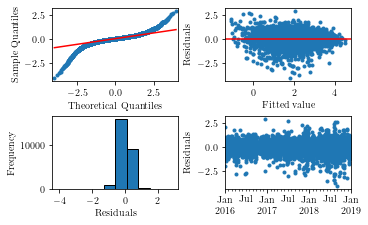

In [95]:
# PM10
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout = True, figsize = (5, 3))

# QQ-plot of studentized residuals
sm.qqplot(lmod.resid, line='q', ax=ax1, marker=".")
# ax1.annotate('(a)', xy=(0, 1.09), xycoords="axes fraction")

# fitted vs residuals
ax2.scatter(lmod.fittedvalues, lmod.resid, marker=".")#, facecolors='none', edgecolors='#1f77b4')
ax2.axhline(0, color='r')
ax2.set_xlabel('Fitted value')
ax2.set_ylabel('Residuals')
# ax2.annotate('(b)', xy=(0, 1.09), xycoords="axes fraction")

ax3.hist(lmod.resid, edgecolor='black')
ax3.set_xlabel('Residuals')
ax3.set_ylabel('Frequency')
# ax3.annotate('(c)', xy=(0, 1.09), xycoords="axes fraction")

lmod.resid.plot(linestyle="", marker='.', ax=ax4)
ax4.set_xlabel('')
ax4.set_ylabel('Residuals')
# ax4.annotate('(d)', xy=(0, 1.09), xycoords="axes fraction")

# plt.savefig('../plots/Residual_plots_MLR_PM10.pdf')

In [96]:
# make new predictions
y_test = df_PM10_test['PM$_{10}$, Stockholm Torkel Knutssonsgatan'] # keep the target y in original scale
X_test = df_PM10_test[[i for i in df_PM10_train.columns if 'lag' in i]] # only lagged values
# X_test = np.log(X_test) # log transform test data
# # possibility to exclude some stations
X_test = X_test[stations]
X_test.insert(0, 'intercept', 1) # insert column of ones in test data

In [97]:
# if temporal signals are to be included
X_test = X_test.merge(df_weather_test.iloc[:,n1:n2], on='date')

# if weather parameters are to be included
df_weather_test = df_weather_test.iloc[:, w]
df_weather_norm_test = (df_weather_test-df_weather_test.min())/(df_weather_test.max()-df_weather_test.min())
X_test = X_test.merge(df_weather_norm_test, on='date')

In [100]:
# check if columns in train and test matrices are same
all(X_test.columns == X_train.columns)

True

In [101]:
df_PM10_predictions = np.exp(lmod.get_prediction(X_test).summary_frame()) 
# df_PM10_predictions = lmod.get_prediction(df_PM10_test).summary_frame()

# metrics
print('RMSE:')
print(np.sqrt(mean_squared_error(df_PM10_predictions['mean'], y_test)).round(4))
print('\nMAPE:')
print(mean_absolute_percentage_error(df_PM10_predictions['mean'], y_test).round(4))

RMSE:
3.6499

MAPE:
0.2915


# Ridge regression

In [118]:
X_train_ridge = X_train.drop(columns='intercept', axis=1)
y_train_ridge = y_train[:]
X_test_ridge = X_test.drop(columns='intercept', axis=1)

# X_train_ridge = np.exp(X_train.drop(columns='intercept', axis=1))
# y_train_ridge = np.exp(y_train[:])
# X_test_ridge = np.exp(X_test.drop(columns='intercept', axis=1))

y_test_ridge = y_test[:]

In [119]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler2 = MinMaxScaler()

X_train_ridge_scaled = scaler1.fit_transform(X_train_ridge)
y_train_ridge_scaled = scaler2.fit_transform(y_train_ridge.to_frame())
X_test_ridge_scaled = scaler1.transform(X_test_ridge)

Text(0, 0.5, 'Coefficients')

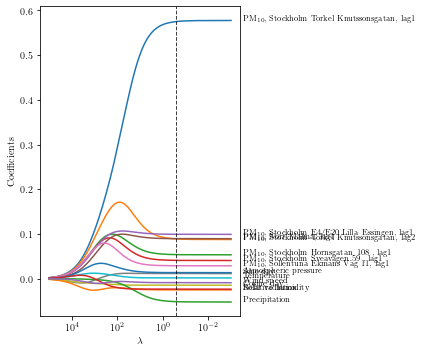

In [120]:
from itertools import chain
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

n_alphas = 250
alphas = np.logspace(-3, 5, n_alphas)
coefs = []
for a in alphas:
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X_train_ridge_scaled, y_train_ridge_scaled)
    coefs.append(list(chain(*ridge.coef_)))
    # coefs.append(ridge.coef_)

# select value of alpha with cross-validation
pars = {'alpha':np.logspace(-3, 5, n_alphas)}
rr = GridSearchCV(linear_model.Ridge(), pars, scoring='r2', cv=10)
rr.fit(X_train_ridge_scaled, y_train_ridge_scaled)
bestalpha = rr.best_params_['alpha']

fig, ax = plt.subplots(figsize=(6, 5), tight_layout=True)
# ridge trace plot
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])
for i in range(len(X_train_ridge.columns)):
    ax.text(min(alphas)/3.25, coefs[0][i], X_train_ridge.columns[i], fontsize=8)
ax.axvline(bestalpha, color='k', linestyle='--', linewidth=1, alpha=.75)
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('Coefficients')
# plt.savefig('../plots/ridge_trace_plot.pdf')

In [122]:
# new predictions with ridge regression
rrbest = linear_model.Ridge(alpha=bestalpha, fit_intercept=True)
rrbest.fit(X_train_ridge_scaled, y_train_ridge_scaled)

print('RMSE:') 
print(np.sqrt(mean_squared_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test_ridge_scaled))), y_test_ridge)).round(5))
# print(np.sqrt(mean_squared_error(scaler2.inverse_transform(rrbest.predict(X_test_ridge_scaled)), y_test_ridge)).round(5))

print('\nMAPE:')
print(mean_absolute_percentage_error(np.exp(scaler2.inverse_transform(rrbest.predict(X_test_ridge_scaled))), y_test_ridge).round(5))
# print(mean_absolute_percentage_error(scaler2.inverse_transform(rrbest.predict(X_test_ridge_scaled)), y_test_ridge).round(5))

RMSE:
3.65239

MAPE:
0.29145
